### Goal: Explanatory Data Analysis and Revenue Forecasting
Date: January 2023

### Packages

In [1]:
# import packages
import calendar
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

# packages for forecast
from scalecast import GridGenerator
from scalecast.auxmodels import mlp_stack
from scalecast.Forecaster import Forecaster
from scalecast.Pipeline import Pipeline, Transformer, Reverter

#### Read in data


In [2]:
# read in the data
vendor_map_data = pd.read_csv('m_vendor_map.csv')
transaction_data = pd.read_csv('m_mock_transaction.csv')
active_users_data = pd.read_csv('m_mock_active_users.csv')

#### Part 1: General Analysis

#### User Data

In [3]:
active_users_data.head() # data for the active users

,country_code,month,day,relative_active_users
0,country52,1,26,0.575050
1,country67,2,20,0.000012
2,country55,4,21,0.000031
3,country173,2,20,0.000228
4,country192,6,7,0.000001


In [4]:
active_users_data.shape # shape of users data

(36806, 4)

#### Transaction Data: Breakdown and Analysis

In [5]:
transaction_data.head()

,account,sku,vendor,country_code,month,day,revenue
0,df2941729e64538aa272bf8d4d26678a,70efdf2ec9b086079795c442636b55fb,vendor26,country177,5,13,21.112176
1,8f475441a9f7ac5d15f861974f8fb2f1,70efdf2ec9b086079795c442636b55fb,vendor26,country204,5,13,86.057251
2,6400e8af8eaa676c8f36c05ee2265ceb,b73ce398c39f506af761d2277d853a92,vendor26,country194,5,14,75.594634
3,5000216823a102631e4ed8e6a892bad5,cfa0860e83a4c3a763a7e62d825349f7,vendor26,country120,5,15,130.192020
4,fcf3c16bb2eb545e319f0c859c64d59b,cfa0860e83a4c3a763a7e62d825349f7,vendor26,country120,5,15,130.192020


In [6]:
transaction_data.shape # shape of transaction data

(729200, 7)

In [7]:
# view the frequency distribution for entries for each vendor
transaction_data.groupby('vendor').agg({'revenue': ['sum','count']}).round(2) # round up to 2 decimal places

revenue        
                  sum   count
vendor                       
vendor11  14304964.98  117659
vendor14       210.79       1
vendor20       330.22       1
vendor25       675.95      14
vendor26  51393985.99  524160
vendor27      1556.67       4
vendor29    166595.22    1661
vendor33   3507710.09   57242
vendor36    247411.29    1418
vendor37    196871.98    1879
vendor42   3198295.55   25160
vendor43        47.14       1

##### Proportion of total revenue?

                  sum   count percent_total
vendor                                     
vendor11   8659461.06   67859        20.12%
vendor14       210.79       1         0.00%
vendor20       330.22       1         0.00%
vendor25       675.95      14         0.00%
vendor26  30130863.27  297341        70.02%
vendor27      1556.67       4         0.00%
vendor29    100703.71     961         0.23%
vendor33   1990050.36   32015         4.62%
vendor36    158289.36     890         0.37%
vendor37    196871.98    1879         0.46%
vendor42   1791567.51   14541         4.16%


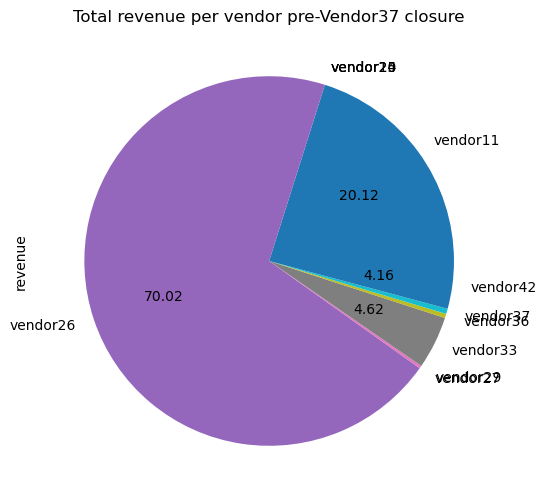

In [81]:
# Look at how much each vendor made in revenue before April 1st - closure of vendor37
transaction_data_pre_April = transaction_data[transaction_data['month'] < 4]
""" 
    visualize the proportion of each vendor's revenue in relation to total revenue by calculating the percent total of each vendors revenue
"""
percent_total = transaction_data_pre_April.groupby('vendor')['revenue'].agg(['sum', 'count']).round(2)
print(percent_total.assign(percent_total = percent_total['sum'].div(percent_total['sum'].sum()).map('{:.2%}'.format)))

# visualize the total revenue for each vendor
plt.ticklabel_format(style = 'plain')
def autopct(pct): # only show the label when it's > 1%
    return ('%.2f' % pct) if pct > 1.00 else ''
transaction_data_pre_April.groupby('vendor')['revenue'].sum().plot(kind='pie', autopct=autopct,title="Total revenue per vendor pre-Vendor37 closure", figsize=(6,6))
plt.show()

                  sum   count percent_total
vendor                                     
vendor11   5645503.91   49800        18.83%
vendor26  21263122.72  226819        70.91%
vendor29     65891.51     700         0.22%
vendor33   1517659.72   25227         5.06%
vendor36     89121.93     528         0.30%
vendor42   1406728.04   10619         4.69%
vendor43        47.14       1         0.00%


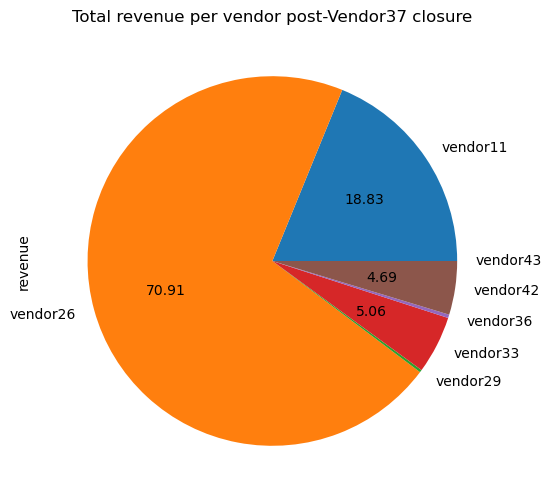

In [80]:
# Look at how much each vendor made in revenue after April 1st - closure of vendor37
transaction_data_post_April = transaction_data[transaction_data['month'] >= 4]

# visualize the proportion of each vendor's revenue in relation to total revenue
percent_total = transaction_data_post_April.groupby('vendor')['revenue'].agg(['sum', 'count']).round(2)
print(percent_total.assign(percent_total = percent_total['sum'].div(percent_total['sum'].sum()).map('{:.2%}'.format)))

# visualize the total revenue for each vendor
plt.ticklabel_format(style = 'plain')
def autopct(pct): # only show the label when it's > 1%
    return ('%.2f' % pct) if pct > 1.00 else ''
transaction_data_post_April.groupby('vendor')['revenue'].sum().plot(kind='pie', autopct=autopct, title="Total revenue per vendor post-Vendor37 closure", figsize=(6,6))
plt.show()

##### Revenue and transactions per day through vendor37?

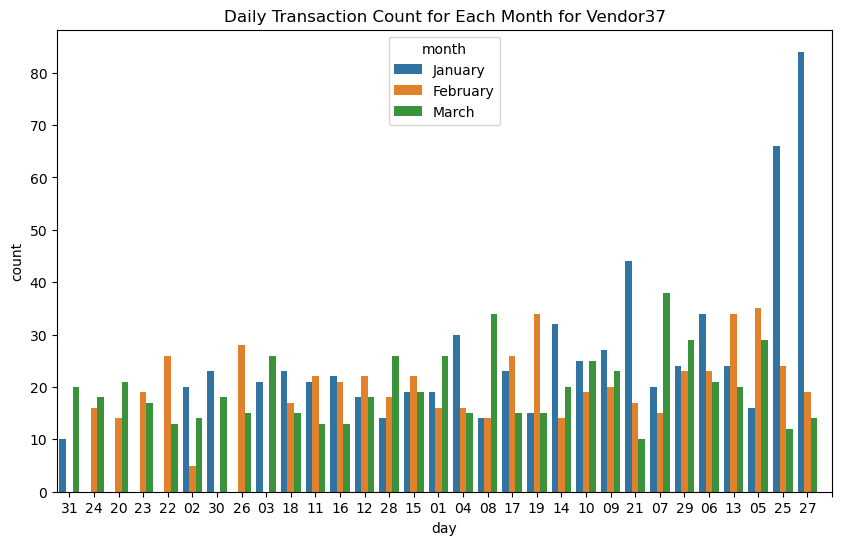

In [10]:
"""  
    First we single out transactions by vendor37 from our original transaction data
    Next, convert month and date to datetime type values
    Then perform a countplot using seaborn to visualize the daily count of Vendor37s transaction for each month the were in operation
"""
vendor37_transactions = transaction_data[transaction_data['vendor'] == 'vendor37']

#vendor37_transactions['month'] = pd.to_datetime(vendor37_transactions['month'], format='%m')
vendor37_transactions['month'] = vendor37_transactions['month'].apply(lambda x: calendar.month_name[x])
vendor37_transactions['day'] = pd.to_datetime(vendor37_transactions['day'], format='%d')
vendor37_transactions['day'] = vendor37_transactions['day'].dt.strftime('%d')

# plot the visualization
plt.figure(figsize=(10,6))
sns.countplot(x='day', hue='month', data=vendor37_transactions, order=reversed(vendor37_transactions['day'].value_counts().index))
plt.title('Daily Transaction Count for Each Month for Vendor37')
plt.xticks(np.arange(0, 32, 1))
plt.show()

##### Daily revenue for each month by vendor37

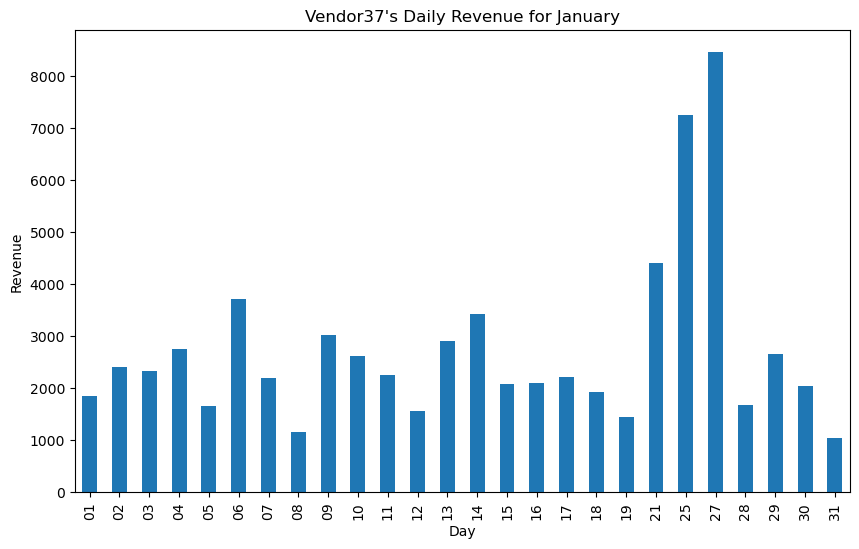

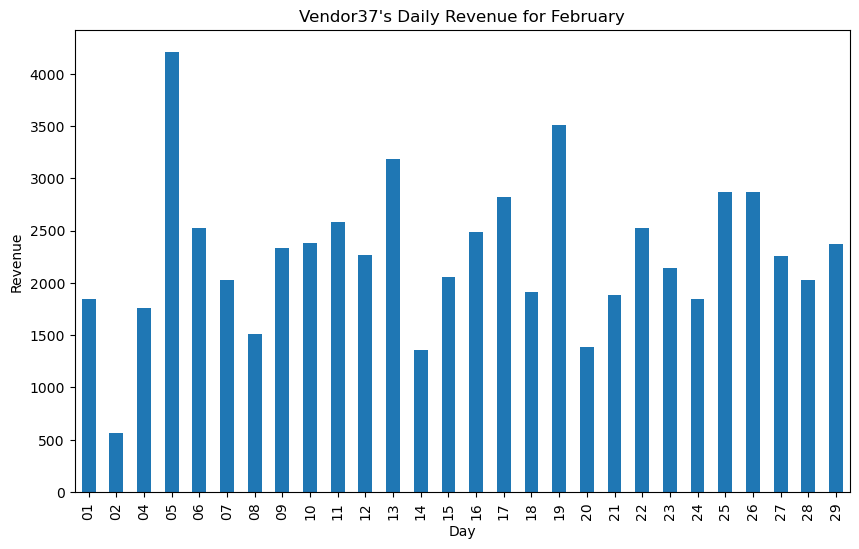

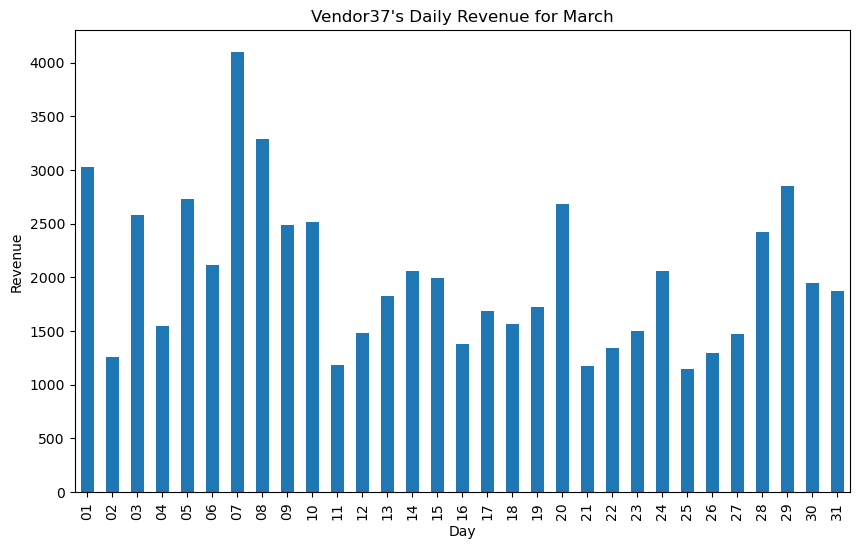

In [11]:
# create a bar plot to visualize the sum of revenue daily for Vendor 37
vendor37_january_transactions = vendor37_transactions[vendor37_transactions['month'] == 'January']
vendor37_february_transactions = vendor37_transactions[vendor37_transactions['month'] == 'February']
vendor37_march_transactions = vendor37_transactions[vendor37_transactions['month'] == 'March']

# create a list for the three months and loop through
all_vendor37_transactions = [vendor37_january_transactions, vendor37_february_transactions, vendor37_march_transactions]

for i in all_vendor37_transactions:
    i.groupby('day').revenue.sum().plot(kind='bar', figsize=(10,6))
    plt.xlabel('Day')
    plt.ylabel('Revenue')
    plt.title('Vendor37\'s Daily Revenue for ' + str(i.month.unique()[0]))
    plt.show()

<AxesSubplot:title={'center':'Total Revenue per Month for Vendor37'}, xlabel='month'>

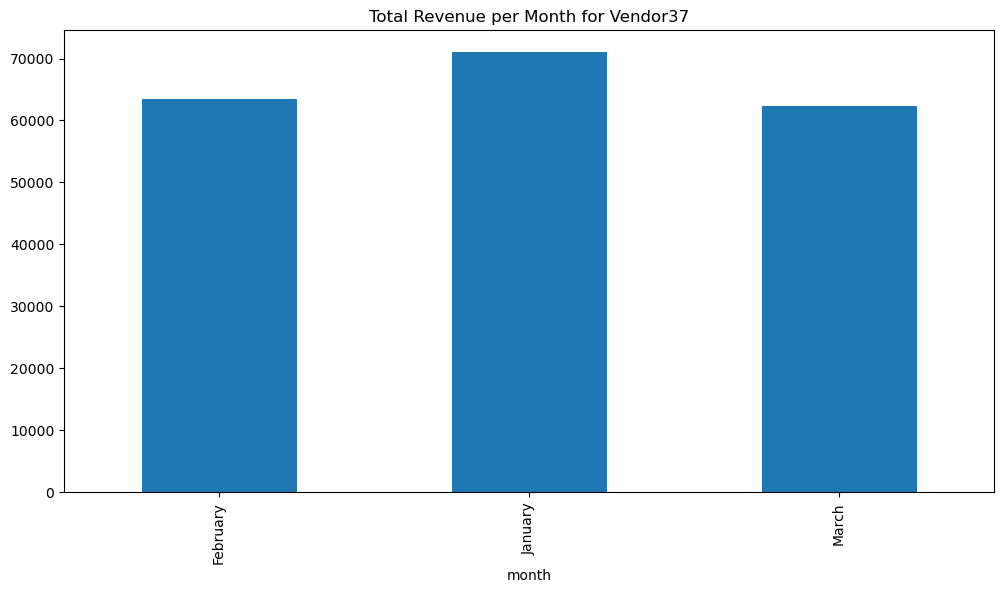

In [12]:
""" 
    A view of the monthly total revenue for Vendor37
"""
vendor37_transactions.groupby('month').revenue.sum().plot(kind='bar', figsize=(12,6), title='Total Revenue per Month for Vendor37')

<AxesSubplot:title={'center':'Total Transactions per Month for Vendor37'}>

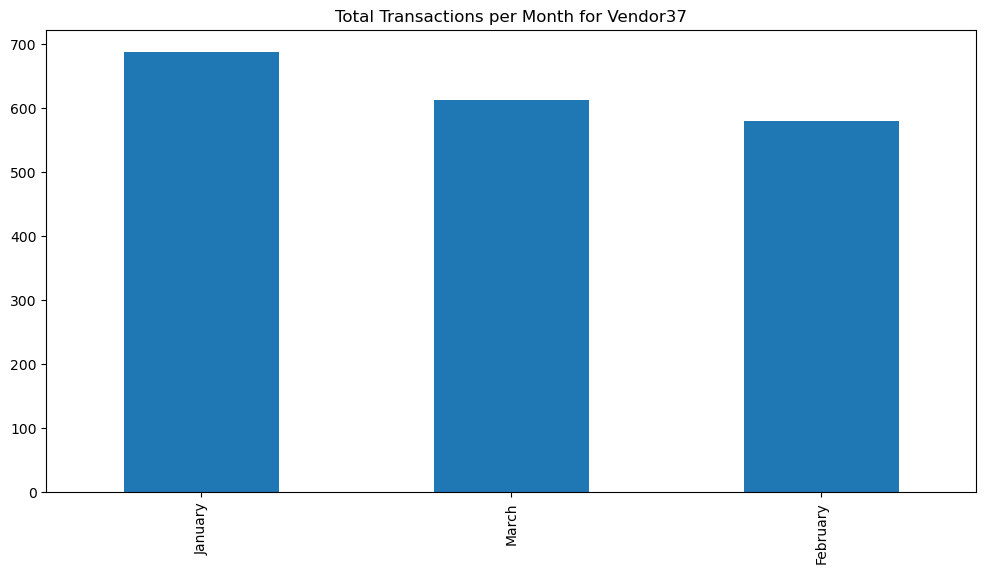

In [13]:
""" 
    A view of the total number of transactions for each month Vendor37 operated.
"""
vendor37_transactions['month'].value_counts().plot(kind='bar', figsize=(12,6), title='Total Transactions per Month for Vendor37')

#### Regional usage details for vendor37?

country66     591
country45     557
country16     175
country214    170
country51     124
country217    109
country52      30
country194     26
country182     12
country20      11
Name: country_code, dtype: int64


<AxesSubplot:title={'center':'Regional usage of Vendor37'}>

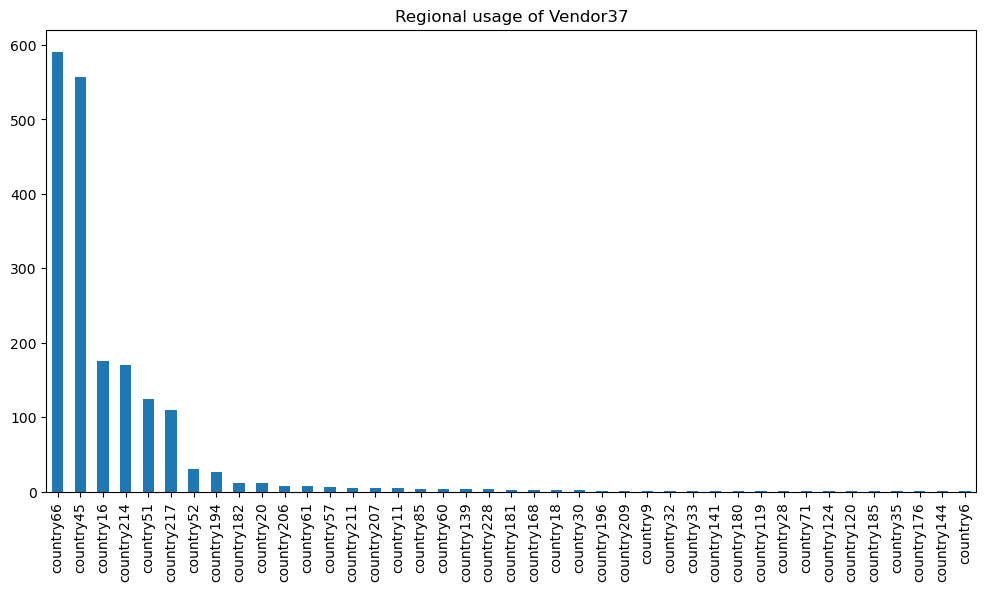

In [14]:
""" 
    To answer the regional usage details, we look at the countries in which vendor 37 operates. We would count the number of transactions that each country made in the 3-month window when they were open.
"""
print(vendor37_transactions['country_code'].value_counts().head(10)) # view the top 10 transacting countries
vendor37_transactions['country_code'].value_counts().plot(kind='bar', figsize=(12,6), title='Regional usage of Vendor37') # visualize the entire transacting countries

##### Number of users expected to be affected by the closure?


In [15]:
"""
    To view the potential number of users to be affected, we look at the unique account IDs which transacted with vendor37 in its month of operation
"""
vendor37_transactions.account.nunique()

1215

1215 unique users are expected to be affected by the closure of Vendor37

#####  Measurable revenue change as a result of the closure (on April 1)? Part A

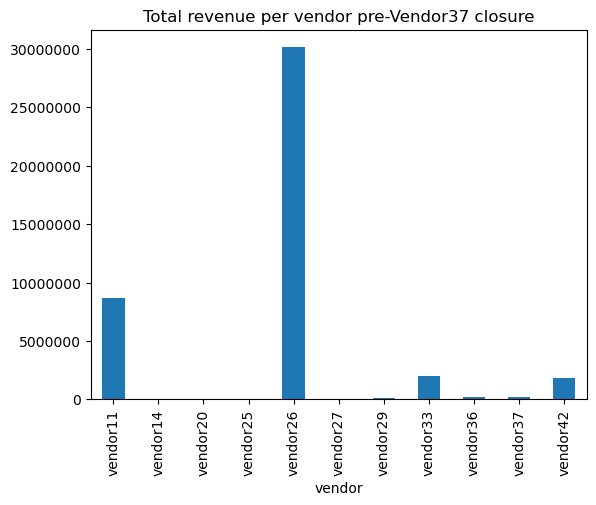

In [16]:
"""
    To measure the revenue change, we view the revenues across vendors in the months preceding April 1st and then the months after.
"""
# Look at how much each vendor made in revenue before April 1st - closure of vendor37
transaction_data_pre_April = transaction_data[transaction_data['month'] < 4]

# visualize the total revenue for each vendor
plt.ticklabel_format(style = 'plain')
transaction_data_pre_April.groupby('vendor')['revenue'].sum().plot(kind='bar', title="Total revenue per vendor pre-Vendor37 closure")
plt.show()

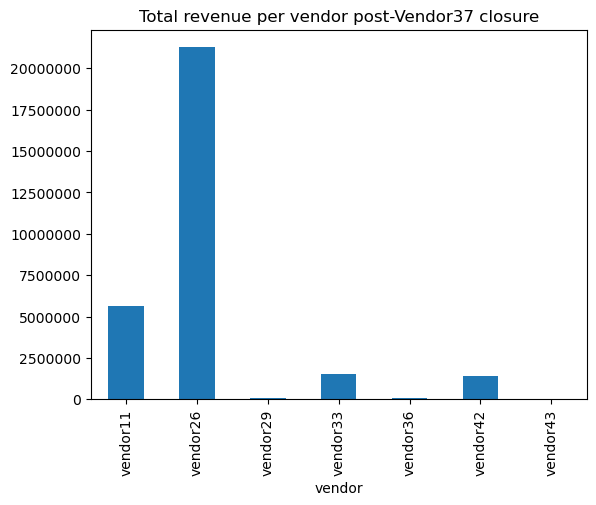

In [17]:
# Look at how much each vendor made in revenue after April 1st - closure of vendor37
transaction_data_post_April = transaction_data[transaction_data['month'] >= 4]

# visualize the total revenue for each vendor
plt.ticklabel_format(style = 'plain')
transaction_data_post_April.groupby('vendor')['revenue'].sum().plot(kind='bar', title="Total revenue per vendor post-Vendor37 closure")
plt.show()

#####  Measurable revenue change as a result of the closure (on April 1)? - Regionally? Part B 

                   sum  count percent_total
country_code                               
country100     1551.98     40         0.00%
country101     4738.89    118         0.01%
country103     3212.11    108         0.01%
country104    74107.01   1703         0.17%
country106      315.50      4         0.00%
...                ...    ...           ...
country91        49.56      2         0.00%
country94       134.93      2         0.00%
country95      1247.56     20         0.00%
country97       107.04      3         0.00%
country98       290.63     10         0.00%

[175 rows x 3 columns]


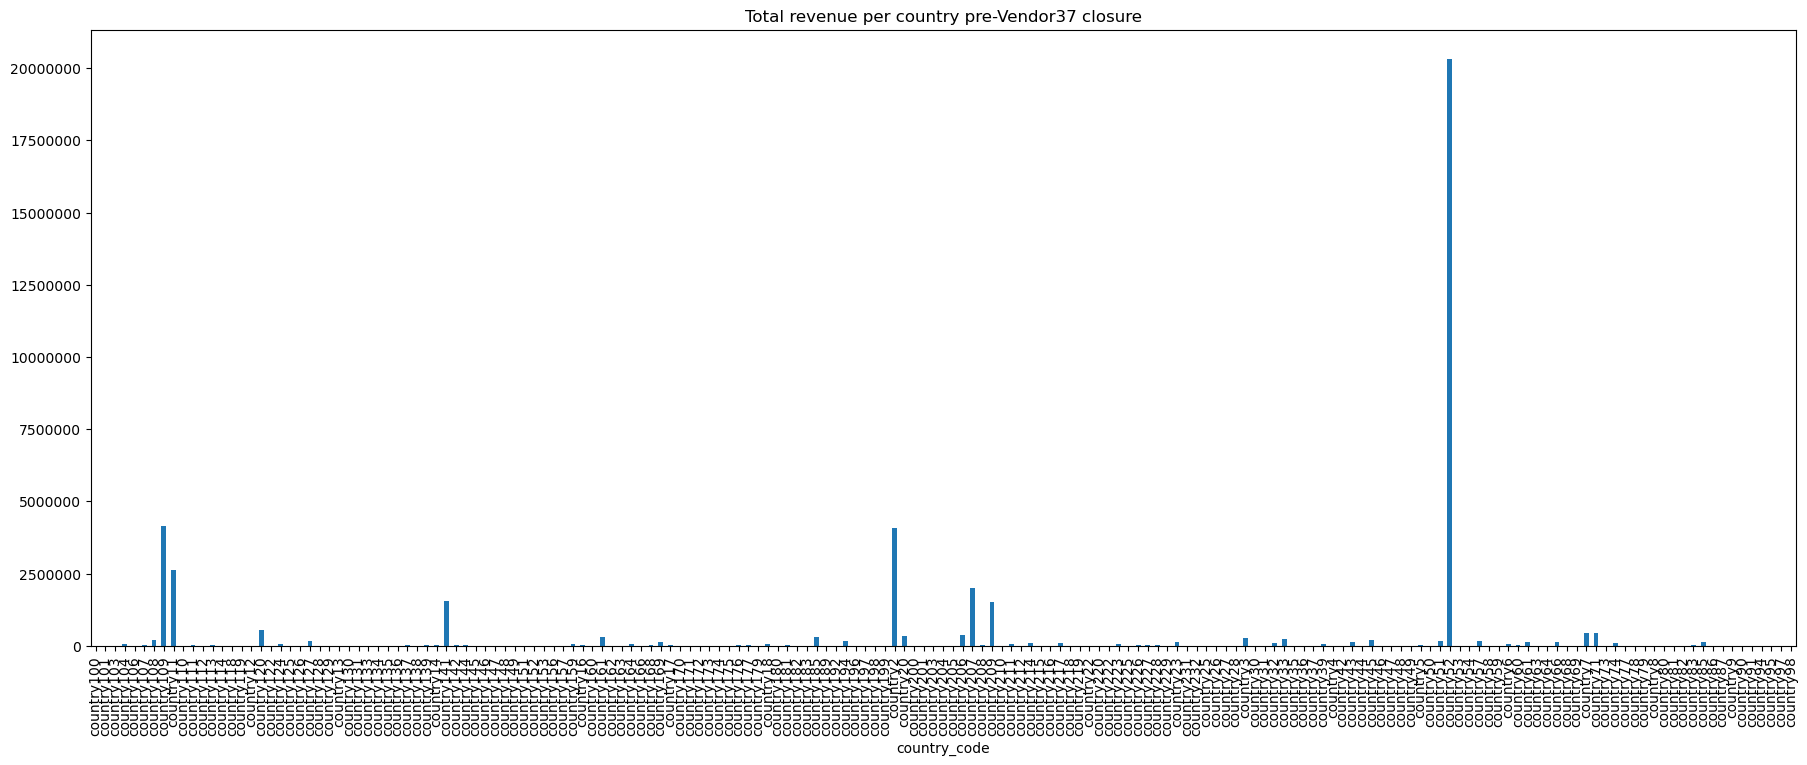

In [18]:
""" 
    We view the revenue change per country
"""
# Look at how much each country made in revenue after April 1st - closure of vendor37
transaction_data_pre_April = transaction_data[transaction_data['month'] < 4]

percent_total = transaction_data_pre_April.groupby('country_code')['revenue'].agg(['sum', 'count']).round(2)
print(percent_total.assign(percent_total = percent_total['sum'].div(percent_total['sum'].sum()).map('{:.2%}'.format)))

# visualize the total revenue per country
plt.ticklabel_format(style = 'plain')
transaction_data_pre_April.groupby('country_code')['revenue'].sum().plot(kind='bar', title="Total revenue per country pre-Vendor37 closure", figsize=(22,8))
plt.show()

                   sum  count percent_total
country_code                               
country100     1259.96     23         0.00%
country101     5121.67    107         0.02%
country103     2510.10     90         0.01%
country104    65843.08   1453         0.22%
country106      379.67      7         0.00%
...                ...    ...           ...
country91       257.82      5         0.00%
country94       214.38      4         0.00%
country95      1476.26     20         0.00%
country97       430.96      9         0.00%
country98       305.66      9         0.00%

[166 rows x 3 columns]


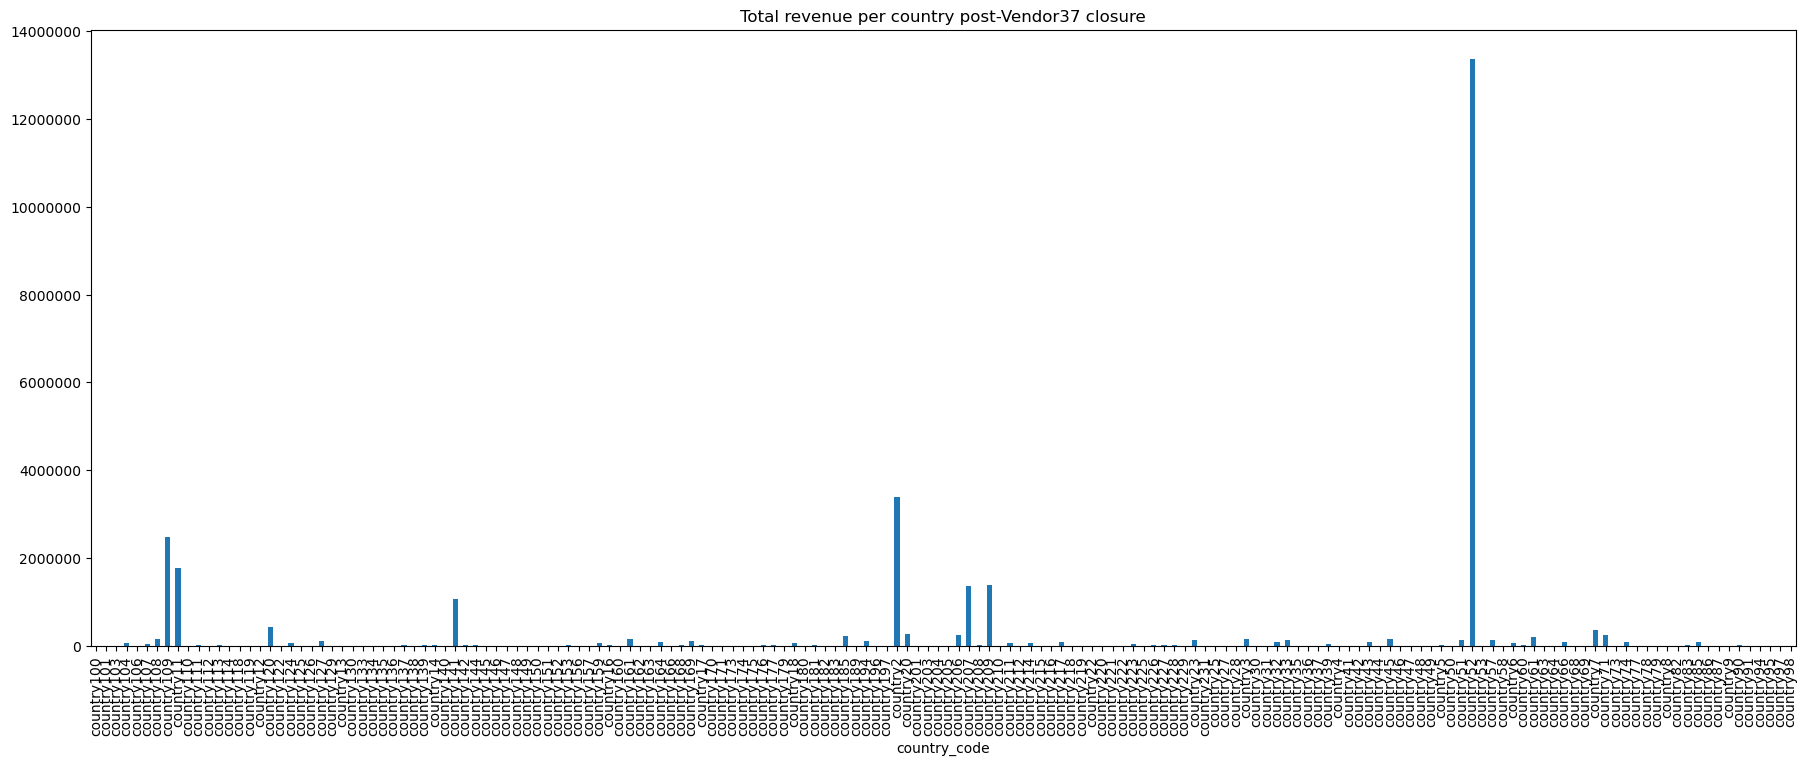

In [19]:
# Look at how much each vendor made in revenue after April 1st - closure of vendor37
transaction_data_post_April = transaction_data[transaction_data['month'] >= 4]

percent_total = transaction_data_post_April.groupby('country_code')['revenue'].agg(['sum', 'count']).round(2)
print(percent_total.assign(percent_total = percent_total['sum'].div(percent_total['sum'].sum()).map('{:.2%}'.format)))

# visualize the total revenue per country
plt.ticklabel_format(style = 'plain')
transaction_data_post_April.groupby('country_code')['revenue'].sum().plot(kind='bar', title="Total revenue per country post-Vendor37 closure", figsize=(22,8))
plt.show()

##### How does the spending of vendor37 users after closure compare to the spending of the users of other vendors?
    . Spending of vendor37 users after closure in comparison to the spending of the users of other vendors

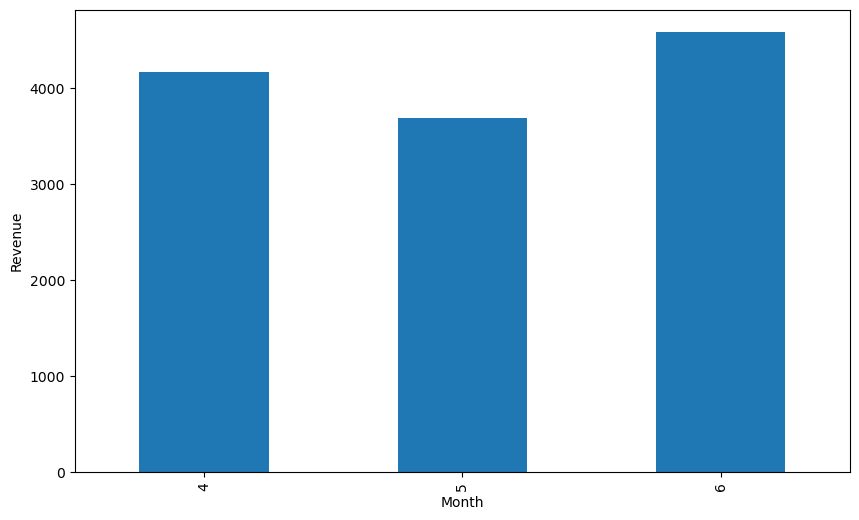

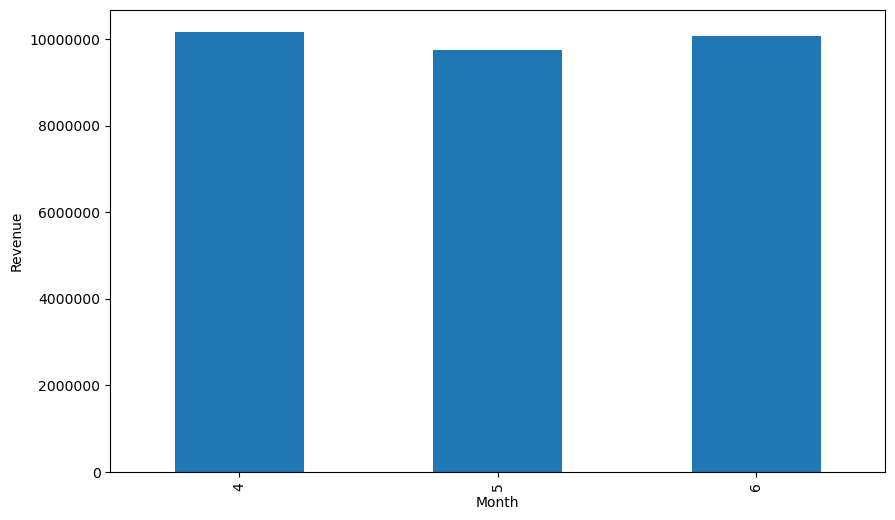

In [20]:
""" 
    Get the users that transacted with Vendor37
    Check if and which vendor they transacted with Post Vendor37 closure and sum their revenue
    Get revenue of users of other vendors
"""
# First we get the list of users that transacted with Vendor37
unique_vendor37_users = vendor37_transactions['account'].drop_duplicates().reset_index()
unique_vendor37_users.columns = ['index', 'account']

#  Next, we check if they exist in the transaction list post Vendor37 closure and create a new column - vendor37_users
#  Would return 1 if the users occur and 0 if None
transacting_users_post_April = transaction_data_post_April.copy().assign(vendor37_users=transaction_data_post_April.account.isin(unique_vendor37_users.account).astype(int)) # would return 1 if the users occur

# From the df created above, we filter out rows which have transactions of migrated users from Vendor37 andlso transaction  other users
migrated_vendor37_users = transacting_users_post_April[transacting_users_post_April['vendor37_users'] == 1]
other_users = transacting_users_post_April[transacting_users_post_April['vendor37_users'] == 0]

# combine both categories in a list and loop through
both_categories = [migrated_vendor37_users, other_users]
for i in both_categories:
    plt.ticklabel_format(style = 'plain')
    i.groupby('month').revenue.sum().plot(kind='bar', figsize=(10,6))
    plt.xlabel('Month')
    plt.ylabel('Revenue')
    plt.show()

The first plot above shows the spending of Migrated Vendor37 users for the month of April, May and june. While the second plot shows the spending of Other users for the respective months. In the post closure era of Vendor37, the plot tells us that other users spent nearly 30million, in comparison to the near 15,000 spent by Migrated vendor37 users. 

##### Is there any indication that vendor37 users have migrated to new vendors?

In [21]:
# Filter out rows which have transactions of users from Vendor37
migrated_users = transacting_users_post_April[transacting_users_post_April['vendor37_users'] == 1]

migrated_users['account'].nunique()

98

98 unique users from Vendor37 have migrated to other vendors

#### Vendor Map Data

In [22]:
vendor_map_data.head()

,vendor_id,fee_percentage
0,vendor1,10.0
1,vendor2,NaN
2,vendor3,NaN
3,vendor4,NaN
4,vendor5,NaN


In [23]:
vendor_map_data.shape

(44, 2)

<AxesSubplot:>

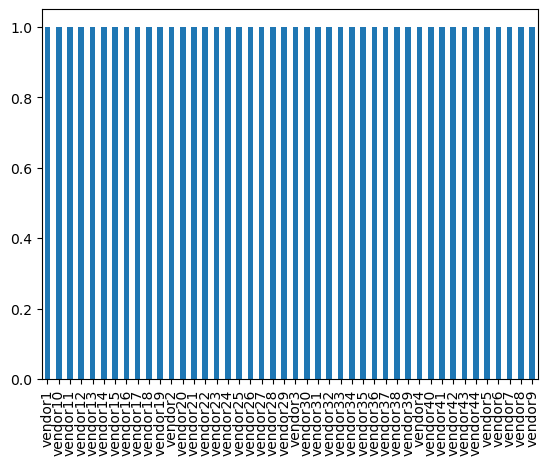

In [24]:
vendor_map_data['vendor_id'].value_counts().sort_index().plot.bar()

### Part 2: Modelling
    * I would apply a number of models to forecast possible future revenues over a 90 day period if Vendor37 had not been closed.
    * Model used are:
        * MLR
        * Random Forest
        * XGBoost
        * Ensemble Learning - Weighted Average of the 3 models 



In [25]:
import math
import warnings
import pmdarima as pm

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [26]:
def plot_test_export_summaries(f):
    """ 
        exports the relevant statisitcal information and displays a plot of the test-set results for the last model run
    """
    f.plot_test_set(models=f.estimator,ci=True)
    plt.title(f'{f.estimator} test-set results',size=16)
    plt.show()
    return f.export('model_summaries',determine_best_by='TestSetMAPE')[
        [
            'ModelNickname',
            'HyperParams',
            'TestSetMAPE',
            'TestSetR2',
            'InSampleMAPE',
            'InSampleR2'
        ]
    ]

In [53]:
""" 
    First, we want to predict what revenues would be if Vendor37 was not closed.
    Hence, we would take into account months where vendor37 operated form original transaction data. January, February, March
    To get a better view of the trend, I would add more points by combining both month and day columns.
    I am also going to assume a date of 2020 for all datapoints to make it a full date. 2020 because I observed February 29 (leap year indication) in the data.
"""

transaction_data_pre_April_copy = transaction_data_pre_April.copy() # create a copy of the dataset
transaction_data_pre_April_copy['month'] = transaction_data_pre_April_copy.month.map("{:02}".format)  # expand the months from single digits to double i.e 1 to 01
transaction_data_pre_April_copy['day'] = transaction_data_pre_April_copy.day.map("{:02}".format)     # expand the days from single digits to double i.e 9 to 09

transaction_data_pre_April_copy['full_date'] = '2020' + '/' + transaction_data_pre_April_copy['month'].astype(str) + '-' + transaction_data_pre_April_copy['day'].astype(str)  # convert to string so we can concatenate
transaction_data_pre_April_copy['full_date'] = pd.to_datetime(transaction_data_pre_April_copy['full_date'], infer_datetime_format=True)           # convert to datetime format

In [54]:
""" 
    For the forecasting, I am using the Scalecast wrapper method. The wrapper allows for easy implementation and fine-tuning of several traditional and deep learning models. i.e boosting and neural network inclusive.
    More info can be found here: https://scalecast.readthedocs.io/en/latest/about.html
"""

from scalecast.Forecaster import Forecaster # import the Forecaster package

#transaction_data_week_pre_April = transaction_data_week_pre_April.set_index('full_date')
f = Forecaster(y=transaction_data_pre_April_copy['revenue'], current_dates=transaction_data_pre_April_copy['full_date']) # use a copy of the dataset

##### Autocorrelation and Partial correlation tests

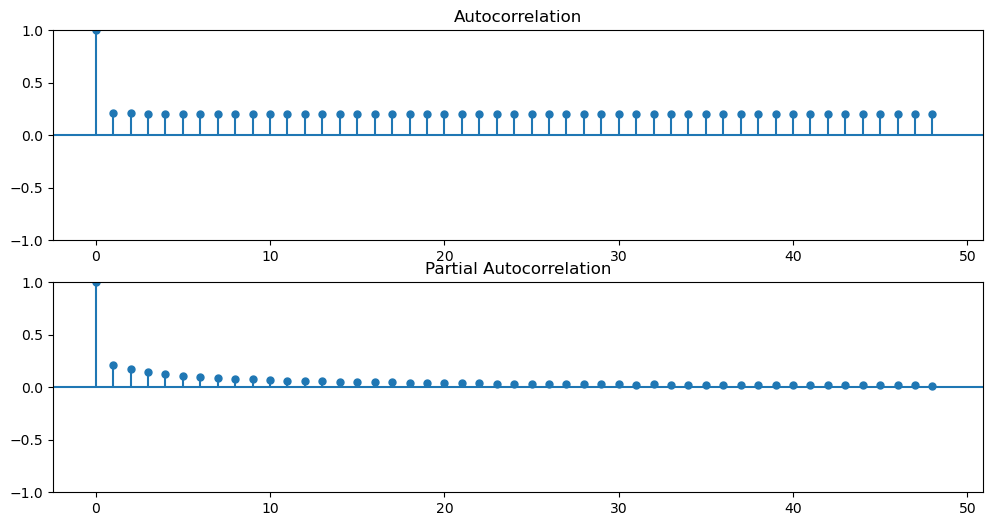

In [30]:
""" 
    Next, I want to observe the following from the data:
        1. do current values correlate with past values? 
        2. what is the seasonal nature of the data like?
        3. is the data stationary?
"""
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(ax=axs[0],lags=48)
f.plot_pacf(ax=axs[1],lags=48)
plt.show()

##### Stationary test using Dickey-Fuller Method

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -15.21
the p-value is 0.0000
the series is stationary
----------------------------------------------------------------------------------------------------


<AxesSubplot:xlabel='Date', ylabel='Values'>

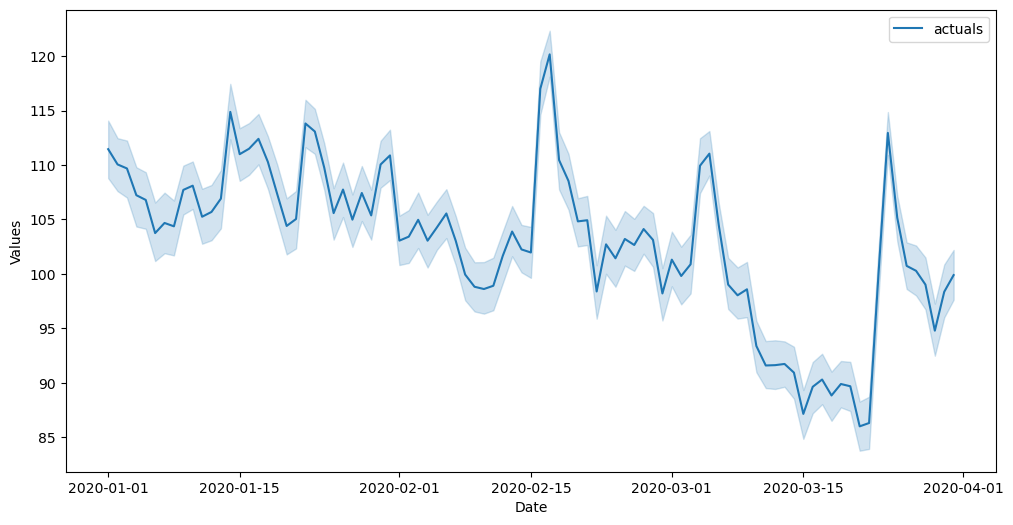

In [31]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

f.plot()

##### Run models
    
##### First I will use a Multiple Linear Regression to serve as a benchmark

* Set test length (20% split)
* Generate forecast using forecast length of 90 days
* Set CI level to 90% to make intervals less noticeable in graphs
* add time series regressors
* add autoregressive terms

In [38]:
f.set_test_length(0.2) # 20 days
f.generate_future_dates(90)
f.set_cilevel(.90)
f.add_ar_terms(7)
f.add_AR_terms((4,7))
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')

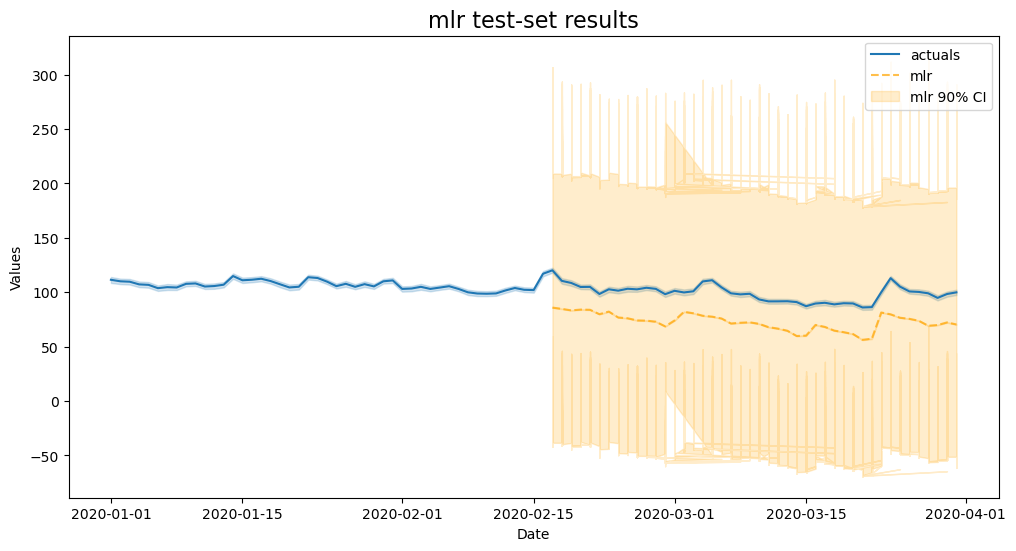

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,mlr,{},1.186585,-0.532353,1.678024,0.157972


In [39]:
f.set_estimator('mlr')
f.manual_forecast(dynamic_testing=90)
plot_test_export_summaries(f)

On the test-set performance, MLR seemed to have underforcasted the revenue values for days leading towards the end of the cycle. However, it's trend line is in very good comparison with the original trend line.

##### Plot the Forecast using Multiple Linear Regression

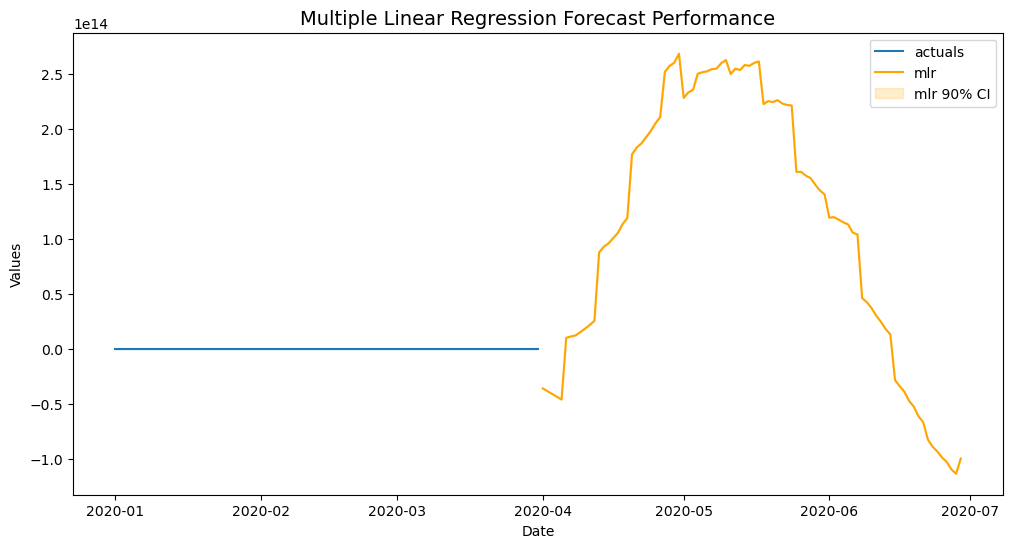

In [42]:
f.plot(ci=True, models='mlr')
plt.title('Multiple Linear Regression Forecast Performance',size=14)
plt.show()

The MLR model shows a very sharp increase in revenue as well as a very sharp decrease in revenue. The model seems to perform slightly well on the test set but performs poorly during forecast.

##### Next, I would repeat the forecast step with a RandomForest model to serve a Check 

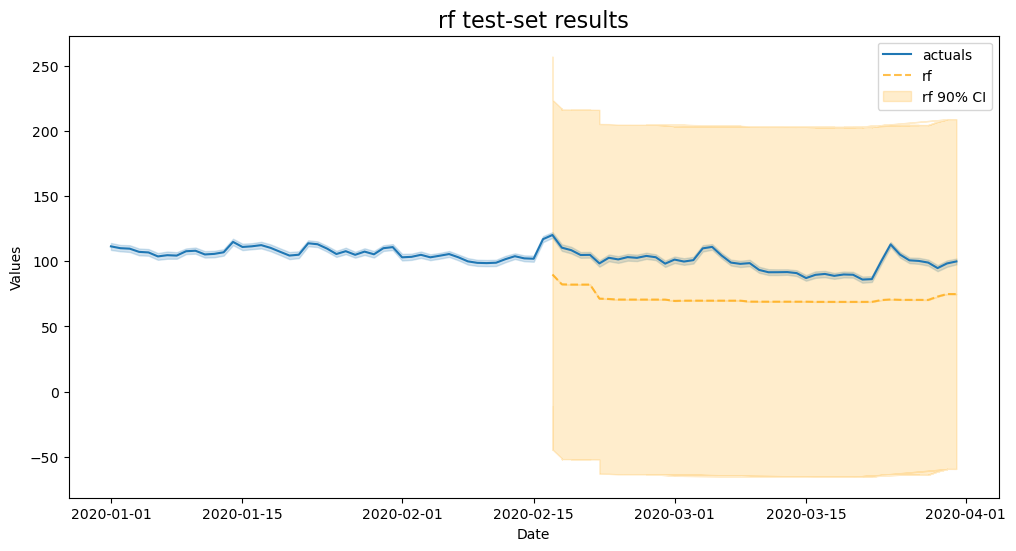

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,rf,"{'max_depth': 5, 'n_estimators': 500, 'max_fea...",1.170352,-0.555691,1.722792,0.145202
1,mlr,{},1.186585,-0.532353,1.678024,0.157972


In [43]:
f.set_estimator('rf')
rf_grid = {
     'max_depth':[2,3,4,5],
     'n_estimators':[100,200,500],
     'max_features':['auto','sqrt','log2'],
     'max_samples':[.75,.9,1],
 }
f.ingest_grid(rf_grid)
f.cross_validate(k=3)
f.auto_forecast()
plot_test_export_summaries(f)

##### Plot the Forecast using Random Forest

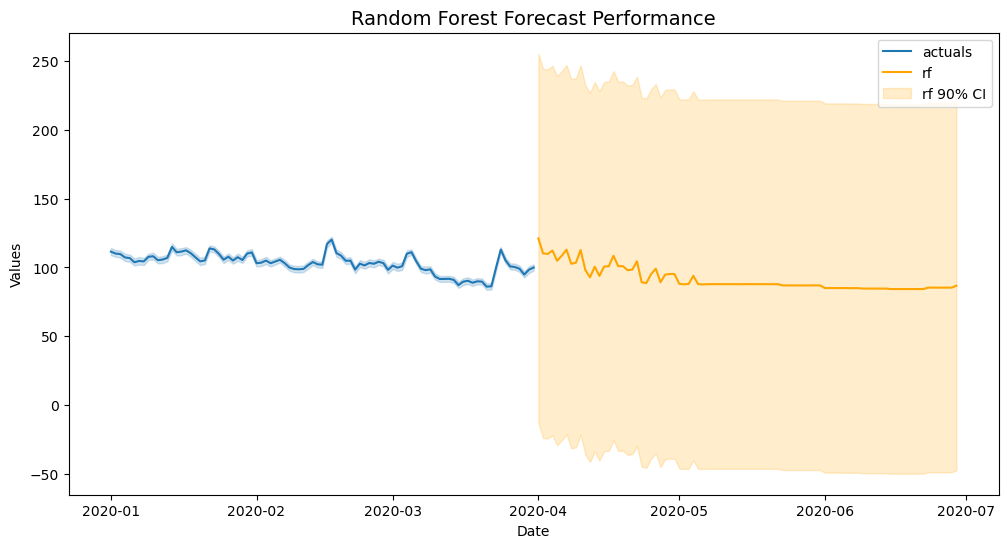

In [45]:
f.plot(ci=True,models='rf')
plt.title('Random Forest Forecast Performance',size=14)
plt.show()

On Forecasting, the RF model seems to give a good/relative result. For the forecasted 90 days ahead, it gives a trend similar to previous months and tends to flatten from the middle of May all the way through June and then starts to pick up towards the end of the month. As can be observed in the Mean Absolute Percentage Error, RF has a lower score in comparison to MLR. This means the values of the forecast are much more closer to the values in our original dataset.

##### Running a third model using XGBoost 

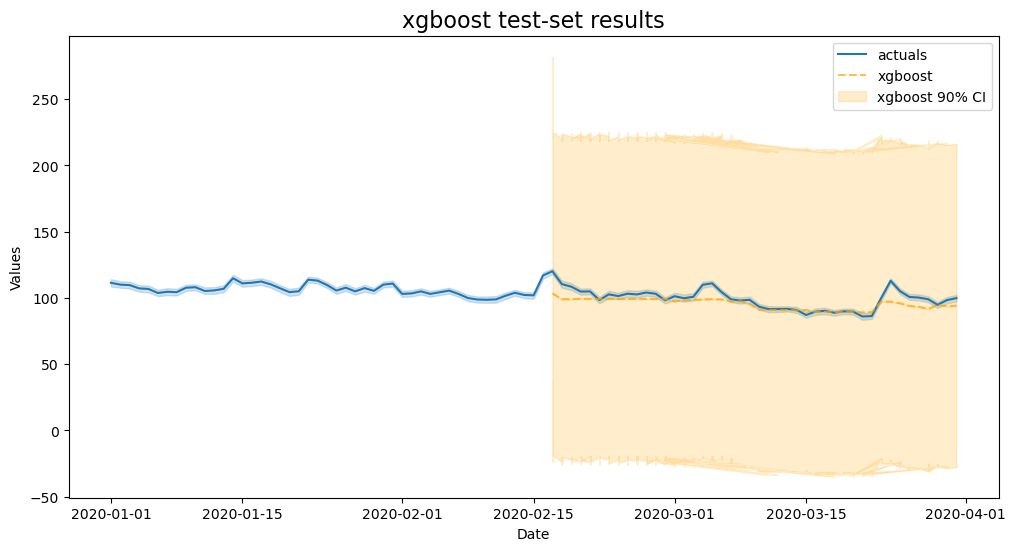

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,rf,"{'max_depth': 5, 'n_estimators': 500, 'max_fea...",1.170352,-0.555691,1.722792,0.145202
1,mlr,{},1.186585,-0.532353,1.678024,0.157972
2,xgboost,"{'n_estimators': 150, 'scale_pos_weight': 5, '...",1.457965,-0.234220,1.639635,0.211232


In [46]:
f.set_estimator('xgboost')
xgboost_grid = {
     'n_estimators':[150,200,250],
     'scale_pos_weight':[5,10],
     'learning_rate':[0.1,0.2],
     'gamma':[0,3,5], 
     'subsample':[0.8,0.9]
}
f.ingest_grid(xgboost_grid)
f.cross_validate(k=3)
f.auto_forecast()
plot_test_export_summaries(f)

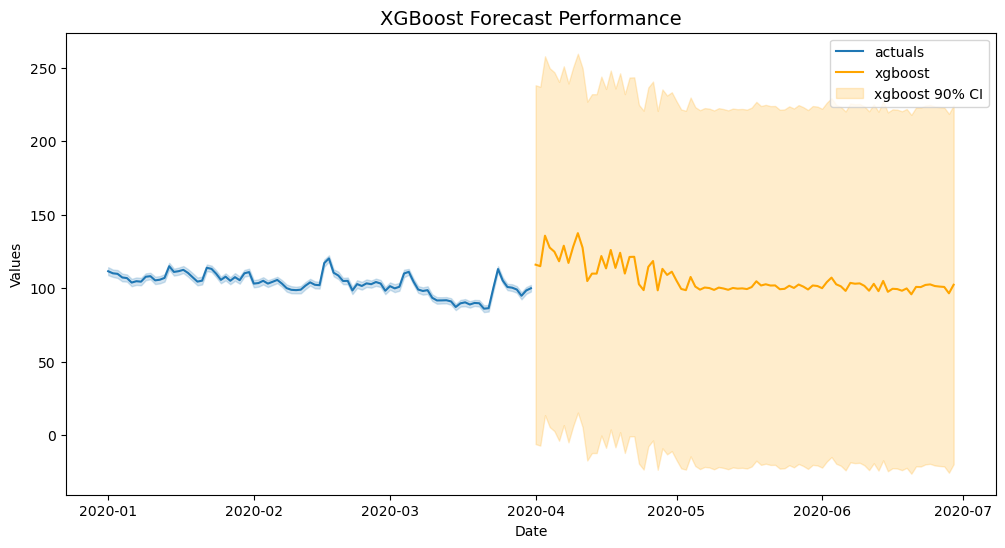

In [47]:
f.plot(ci=True,models='xgboost')
plt.title('XGBoost Forecast Performance',size=14)
plt.show()

Modelling with XGBoost seems to slightly overfit. As it performs well on the test set but slightly less on the forecast. It has the worst MAPE values in comparison to the MLR and RF models.

Create a forecast by combining the Weighted Average of the 3 models - Ensemble Learning
* The best model is determined by the values of their ValidationMetricValue

In [ ]:
f.manual_forecast(how='weighted', models=['mlr','rf','xgboost'], determine_best_by='ValidationMetricValue', call_me='weighted_avg')

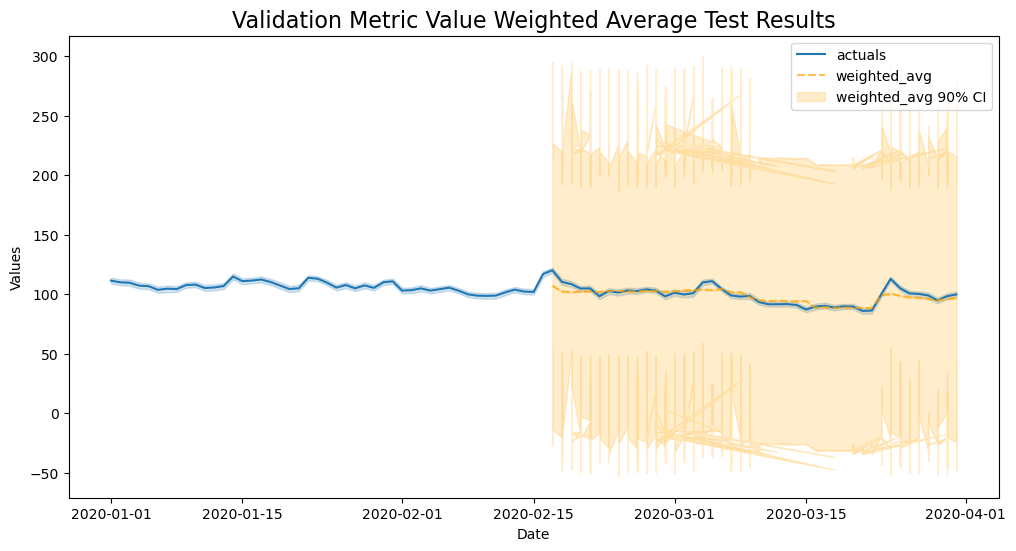

In [52]:
f.plot_test_set(ci=True, models='weighted_avg')
plt.title('Validation Metric Value Weighted Average Test Results',size=16)
plt.show()

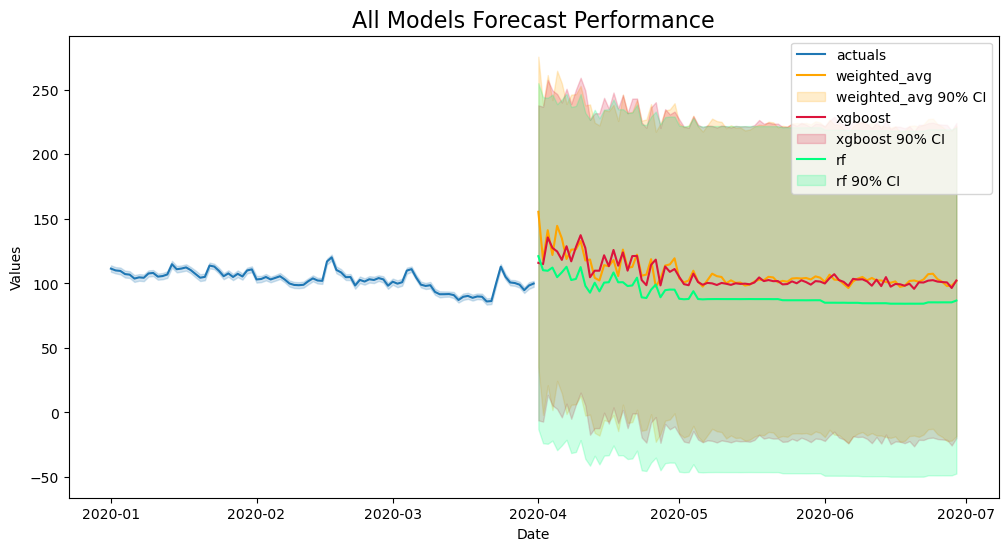

In [50]:
f.plot(order_by='ValidationMetricValue', ci=True)
plt.title('All Models Forecast Performance',size=16)
plt.show()

Conclusion: Of the 4 models, the Weighted average model(ensemble learning) performed best on the test set and also on the forecasted result. Random Forest came in a close second. Tuning the parameters of Random Forest and XGBoost can be further explored to see if the overall prediction output increase. As this would inturn increase the performance of the ensemble model. I believe MLR would perform much if additional independent variables are explored and included during model building.